In [2]:
import pandas as pd
import numpy as np
import os
import random
import json
import tiktoken
from transformers import AutoTokenizer
from huggingface_hub import login
from evaluation_funcs import load_txt_files_to_df
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_metric
import re

from openai import OpenAI
client = OpenAI()




None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
login()

In [3]:
def save_openai_batch_result(batch_file, jsonl_file):

    """ 
    Small function to help keep the openai batch process clean. downloads the batch file and saves it as a jsonl file
    """

    result = client.files.content(batch_file).content

    with open(jsonl_file, 'wb') as file:
        file.write(result)


def convert_opanai_jsonl_to_df(jsonl_file):

    """ 
    Loads a jsonl file returned from the openai batch process. Returns a dataframe containing only the most useful information
    """

    results = []
    with open(jsonl_file, 'r') as file:
        for line in file:
            # Parsing the JSON string into a dict and appending to the list of results
            json_object = json.loads(line.strip())
            necessary_data = {
                'id': json_object['custom_id'],
                'post_lm_text': json_object['response']['body']['choices'][0]['message']['content']
            }
            necessary_data.update(json_object['response']['body']['usage'])
            results.append(necessary_data)
    return pd.DataFrame(results)

def pre_evaluation_processing(df, ground_truth_df, post_lm_text, gt_text ):
    df['id'] = df['id'].str.replace('filename_', '')

    df = df.merge(ground_truth_df.set_index('file_name'), left_on = 'id', right_index = True)
    #df['post_lm_text2'] = df['post_lm_text'].apply(extract_first_match)
    df[post_lm_text] = df[post_lm_text].str.replace("\n", "").str.lower()
    df[gt_text] = df[gt_text].str.replace("\n", "").str.lower()
    df.reset_index(inplace=True)

    return df

def evaluate_model(df, metric_obj, gt_text, post_lm_text):

    """ 
    Uses a huggingface metric to evaluate the results
    """
    
    # Calculate CER for each pair
    results = []
    for index, row in df.iterrows():
        ground_truth_text = row[gt_text]
        response_text = row[post_lm_text]
        result = metric_obj.compute(predictions=[response_text], references=[ground_truth_text])
        results.append(result)

    df['cer'] = results

    return df


# Create the silverset

- set seed
- for each file
    - load file
    - remove all entries greater than smaller than 100 tokens, above acceptable noise

- concatenate to single data frame




In [3]:
os.listdir('./data/ncse_text_chunks')

['ncse_base_1.parquet',
 'ncse_base_6.parquet',
 'ncse_base_0.parquet',
 'ncse_base_5.parquet',
 'ncse_base_2.parquet',
 'ncse_base_4.parquet',
 'ncse_base_3.parquet']

In [2]:
#temp_df = pd.read_parquet('./data/ncse_text_chunks2/'+'ncse_base_1.parquet')

In [3]:
target_dir = './data/transcripts/transcription_files'

files_in_directory =  set(os.listdir(target_dir))

all_data_df = []

for file in os.listdir('./data/ncse_text_chunks'):

     temp_df = pd.read_parquet('./data/ncse_text_chunks/'+file)
     temp_df['entire_article'] = temp_df[['continuation_from_id','continuation_to_id']].isna().sum(axis = 1)==2
     temp_df =  temp_df.loc[temp_df['total_tokens']>100,['id', 'total_tokens', 'symbol_fract', 'entire_article','publication_id', 'file_name', 'content_html']]
     all_data_df.append(temp_df)

all_data_df = pd.concat(all_data_df)


In [ ]:
#proper tokenization is important as llama3 has 3x the vocabulary so will produce fewer tokens for a given text than llama2

In [7]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
def extract_first_x_tokens(text, tokenizer, max_tokens = 1000):
    """
    Extract the first 1000 tokens from a string using the hugginface tokenizer. It ensures that
    the number of tokens in each string does not exceed the limit for a specific model or
    finetuning budget

    Parameters:
    text (str): The input string.
    tokenizer: The tokenizer object for the model of interest
    max_tokens: The maximum number of tokens

    Returns:
    str: The string containing the first 1000 tokens.
    """

    # Tokenize the input text
    tokens = tokenizer.encode(text)

    # Extract the first x tokens
    first_1000_tokens = tokens[:max_tokens]

    # Decode the tokens back to string
    truncated_text = tokenizer.decode(first_1000_tokens)
    #re-calc total tokens in text
    total_tokens = len(first_1000_tokens)

    return truncated_text, total_tokens

random.seed(12335)
#remove the transcribed data then sample. This is to keep the test set pure
sampled_data = all_data_df.loc[~all_data_df['file_name'].isin(os.listdir('./data/transcripts/transcription_files')),:].sample(11000) #11000
#reduce to a maximum token size of 1000
sampled_data[['content_html', 'total_tokens_llama']] = sampled_data['content_html'].apply(lambda x: pd.Series(extract_first_x_tokens(x, tokenizer)))
omni_tokenizer = tiktoken.get_encoding("o200k_base")
sampled_data[['content_html_drop', 'total_tokens_omni']] = sampled_data['content_html'].apply(lambda x: pd.Series(extract_first_x_tokens(x, omni_tokenizer, max_tokens=10000)))
sampled_data = sampled_data.drop('content_html_drop', axis = 1)
sampled_data.to_parquet('./data/silver_data.parquet')

In [5]:
sampled_data = pd.read_parquet('./data/silver_data.parquet')


In [31]:
temp_df.describe()

,id,total_tokens,symbol_fract,publication_id,total_tokens_llama,total_tokens_omni,ratio
count,1.100000e+04,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,7.505863e+05,915.475909,0.217735,24.261091,593.797364,588.017000,1.004150
std,1.945087e+05,907.276629,0.133610,3.140817,340.439513,334.197164,0.022444
min,4.078010e+05,101.000000,0.059829,19.000000,87.000000,73.000000,0.754491
25%,5.776925e+05,257.000000,0.144096,20.000000,256.000000,256.000000,0.994986
50%,7.570765e+05,560.000000,0.178465,26.000000,559.000000,554.000000,1.005025
75%,9.213248e+05,1283.250000,0.246445,27.000000,1000.000000,979.000000,1.015152
max,1.073158e+06,10668.000000,2.920792,27.000000,1000.000000,1000.000000,1.397260


<Axes: xlabel='total_tokens_llama', ylabel='Count'>

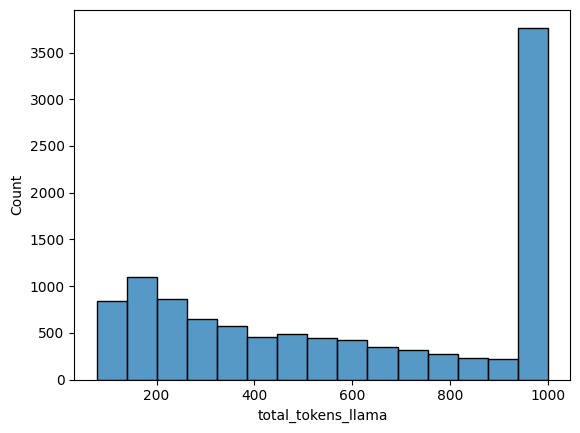

In [32]:
temp_df = sampled_data
temp_df['ratio'] = sampled_data['total_tokens_llama']/sampled_data['total_tokens_omni']
sns.histplot(data = sampled_data, x = 'total_tokens_llama')

In [27]:
sampled_data['total_tokens_llama'].describe()

count    11000.000000
mean       593.797364
std        340.439513
min         87.000000
25%        256.000000
50%        559.000000
75%       1000.000000
max       1000.000000
Name: total_tokens_llama, dtype: float64

In [ ]:
for index, row in sampled_data.iterrows():
    text = row['content_html']
    filename = row['file_name']
    file_path = os.path.join('./data/silver_ocr', filename)

    # Write the text to the file
    with open(file_path, 'w') as file:
        file.write(text)


In [6]:
def create_jsonl_file(df, model, system_content, max_tokens, output_file):
    """
    Create a JSONL file with the specified structure for each row in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    model (str): The model to be used in the 'body' of the JSON.
    system_content (str): The content for the system message.
    max_tokens (int): The max tokens value.
    output_file (str): The path to the output JSONL file.
    """
    with open(output_file, 'w') as file:
        for _, row in df.iterrows():
            entry = {
                "custom_id": f"filename_{row['file_name']}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model,
                    "messages": [
                        {"role": "system", "content": system_content},
                        {"role": "user", "content": row['content_html']}
                    ],
                    "max_tokens": max_tokens
                }
            }
            # Write each JSON object as a separate line in the JSONL file
            file.write(json.dumps(entry) + '\n')



# Specify the arguments
model = 'gpt-4o'
system_content = "You are an expert in recovery of corrupted OCR, the below text is from an English newspaper in the 1800's, please return in plain text, with appropriate spacing and line breaks"
max_tokens = 2200
output_file = './data/output.jsonl'

# Call the function with the DataFrame and arguments
create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, system_content, max_tokens, output_file)


First example taken from the hansard "Disfranchisement Of Sudbury"

https://hansard.parliament.uk/commons/1842-07-06/debates/bd9ca32b-d1b2-4337-bc00-32deed2899e7/DisfranchisementOfSudbury

In [7]:
#silver_instructions_base = "You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text."
#silver_instructions_between = "You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text. place the corrected text between the symbols '</corrected>'"
silver_instructions_historical = "You are an expert in post-OCR correction of historical newspapers. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Do not write anything else than the corrected text."
silver_instructions_ICL = """You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software.Do not write anything else than the corrected text. 
As an example consider the following texts

{
  "corrupted": "The populatlon of that hundrea amounteo to 24,069, ancl he bel1eved that if they ex tenclsd the borou#h, as he des1red, they woulcl secur@ an additlon to the prsent constituen€y of at least 1,000 votors."
  "recovered": "The population of that hundred amounted to 24,069, and he believed that if they extended the borough, as he desired, they would secure an addition to the present constituency of at least 1,000 voters.",
}

{
  "corrupted": "Th3 park 1s a b3autiful pl@ce w1th lush gree.n l@wns, tall tre.es, an& a serene laKe wh3re v1sitors can .*-enjoy a peac3ful walk or a relax1ng boat ride..."
  "recovered": "The park is a beautiful place with lush green lawns, tall trees, and a serene lake where visitors can enjoy a peaceful walk or a relaxing boat ride.",
}

{
  "corrupted": "The res#aurant ser\\es a variet¥ of dis#es, includin fresh seafo9d, sa&ory s+eaks, and delici0us vegetarain opti0ns, al prep*red wth the finset ingrdients."
  "recovered": "The restaurant serves a variety of dishes, including fresh seafood, savory steaks, and delicious vegetarian options, all prepared with the finest ingredients.",
}

You need only return the recovered text

"""


silver_instructions_longprompt = """You are an expert in post-OCR correction of documents. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. Pay close attention to common OCR errors such as misrecognized characters, incorrect spacing, and punctuation issues.


To complete this task, follow these steps:

1. Read through the entire text to understand the context and identify potential errors.
2. Correct any misrecognized characters, such as:
   - Numbers mistaken for letters (e.g., '0' for 'O', '1' for 'I', '5' for 'S')
   - Similar-looking letters (e.g., 'rn' for 'm', 'cl' for 'd')
   - Special characters mistaken for letters or punctuation
3. Fix any spacing issues, ensuring proper word separation and sentence structure.
4. Correct punctuation errors, including misplaced or missing periods, commas, and quotation marks.
5. Ensure proper capitalization, especially at the beginning of sentences and for proper nouns.
6. Maintain the original formatting and structure of the text as much as possible.

Provide your corrected version of the text without any additional explanations or comments. Your output should contain only the corrected text, preserving the original paragraph structure and line breaks.

Begin your corrected text immediately after this instruction, without any introductory phrases or explanations."""

#create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_base, max_tokens, './data/silver_instructions_base.jsonl')
#create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_between, max_tokens, './data/silver_instructions_between.jsonl') using this doesn't work as the model does not reliably return the symbols correctly.
create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_historical, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_historical.jsonl')
create_jsonl_file(sampled_data.reset_index().loc[0:20,:], model, silver_instructions_ICL, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_ICL.jsonl')

In [ ]:


batch_input_file = client.files.create(
  file=open('./data/silver_instructions_base.jsonl', "rb"),
  purpose="batch"
)

In [ ]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "silver_instructions_base"
    }
)

Batch(id='batch_FnoK5q5bQOAKs9GfPOdRdlpi', completion_window='24h', created_at=1720984280, endpoint='/v1/chat/completions', input_file_id='file-bNxRuQZxubqvLpqiAgPpMffe', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1721070680, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'silver_instructions_base'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [14]:
batch_data = client.batches.list(limit=2)
batch_data.data

[Batch(id='batch_SDus5Sr3PQiFTMVyOLDGhBd2', completion_window='24h', created_at=1721735519, endpoint='/v1/chat/completions', input_file_id='file-zgzs5sRSm2vEJ4Y33iZdJedY', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721735669, error_file_id=None, errors=None, expired_at=None, expires_at=1721821919, failed_at=None, finalizing_at=1721735665, in_progress_at=1721735519, metadata={'description': 'silver_instructions_longprompt'}, output_file_id='file-8ANGDnRRYSCe8bQc4ZhYvl3p', request_counts=BatchRequestCounts(completed=91, failed=0, total=91)),
 Batch(id='batch_BeCCUmTFEoc4hAv08gVctYT5', completion_window='24h', created_at=1721733210, endpoint='/v1/chat/completions', input_file_id='file-s2IM3wrz0wyRbgHtIBPg2uLf', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721733272, error_file_id=None, errors=None, expired_at=None, expires_at=1721819610, failed_at=None, finalizing_at=1721733269, in_progress_at=172173

In [10]:
raw_transcript_oct_folder = './data/transcripts/transcription_raw_ocr'

#These are referred to as "gold" as this clearly distinguishes the dataset from any dataframes called test or for testing things in general
raw_gold_ocr_df = load_txt_files_to_df(raw_transcript_oct_folder)
raw_gold_ocr_df['id'] = raw_gold_ocr_df['file_name'].str.split("_periodical", expand = True)[0].str.replace("artid_", "")

enc = tiktoken.get_encoding('o200k_base')
raw_gold_ocr_df['total_tokens'] = raw_gold_ocr_df['content_html'].apply(lambda x:len(enc.encode(x)))

max_tokens = 4000


create_jsonl_file(raw_gold_ocr_df, model, silver_instructions_historical, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_historical.jsonl')
create_jsonl_file(raw_gold_ocr_df, model, silver_instructions_ICL, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_ICL.jsonl')

create_jsonl_file(raw_gold_ocr_df, model, silver_instructions_longprompt, max_tokens, './data/test_prompt_ready_to_batch/silver_instructions_longprompt.jsonl')


In [11]:
batch_input_file = client.files.create(
  file=open('./data/test_prompt_ready_to_batch/silver_instructions_longprompt.jsonl', "rb"),
  purpose="batch"
)

batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "silver_instructions_longprompt"
    }
)

Batch(id='batch_SDus5Sr3PQiFTMVyOLDGhBd2', completion_window='24h', created_at=1721735519, endpoint='/v1/chat/completions', input_file_id='file-zgzs5sRSm2vEJ4Y33iZdJedY', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1721821919, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'silver_instructions_longprompt'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [3]:
file_response = client.files.content('file-NHwN8bGdp9xpveBt1rX8LF2V')

NameError: name 'client' is not defined

In [8]:
def save_batch_data(json_string, output_file):
    """
    Save a string containing multiple JSON objects as a JSONL file.

    Parameters:
    json_string (str): The input string containing JSON objects.
    output_file (str): The path to the output JSONL file.
    """
    # Split the string into individual JSON objects (assuming they are newline-separated)
    json_objects = json_string.strip().split('\n')
    
    with open(output_file, 'w') as file:
        for json_object in json_objects:
            # Convert the string to a dictionary to ensure it is valid JSON
            json_dict = json.loads(json_object)
            # Write the JSON object as a single line
            file.write(json.dumps(json_dict) + '\n')

In [ ]:
save_batch_data(file_response.text, './data/test_return.jsonl')

In [9]:
def convert_batch_to_dataframe(json_string):
    """
    Extract 'custom_id', 'assistant' 'content', and 'usage' from a JSON string and create a DataFrame.

    Parameters:
    json_string (str): The input string containing JSON objects.

    Returns:
    pd.DataFrame: DataFrame containing the extracted data.
    """
    json_objects = json_string.strip().split('\n')
    extracted_data = []

    for json_object in json_objects:
        data = json.loads(json_object)
        custom_id = data['custom_id']
        assistant_content = data['response']['body']['choices'][0]['message']['content']
        usage = data['response']['body']['usage']
        
        row_data = {
            'id': custom_id,
            'corrected_content': assistant_content
        }
        
        # Add the usage dictionary to the row data
        row_data.update(usage)
        
        extracted_data.append(row_data)

    return pd.DataFrame(extracted_data)

In [ ]:
silver_corrected = convert_batch_to_dataframe(file_response.text)

,id,corrected_content,prompt_tokens,completion_tokens,total_tokens
0,request-841530,"MONOMANIA. ISCB—Oh? The Queen has ""popped"" at ...",1182,1062,2244
1,request-751411,* The Plague and the Printing Press: being a B...,322,158,480
2,request-871466,"He performed upon divers of the foremost, who,...",1771,1668,3439
3,request-494321,be having necessary to tramp for the into hous...,672,573,1245
4,request-495935,"""Tomorrow we are going to pillage the archbish...",822,709,1531
...,...,...,...,...,...
86,request-841528,because too much power was placed in the hands...,942,797,1739
87,request-766218,^ ^ ^ ^ ^ ^ ¦ ¦ ¦¦ ¦¦¦¦¦¦¦ ^ ¦¦ ¦ ¦ ^ ^ ¦ ^ ^ ...,189,117,306
88,request-771187,Boo & Co. and in lieu of Miss Braddon's new no...,1302,653,1955
89,request-653700,have been designed: there may therefore be the...,562,456,1018


In [19]:
cer = load_metric("cer")
wer = load_metric("wer")


/tmp/ipykernel_148369/2262283232.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer = load_metric("cer")


In [20]:
corrected_transcript_oct_folder = "./data/transcripts/transcription_files"

corrected_gold_ocr_df = load_txt_files_to_df(corrected_transcript_oct_folder)

raw_ocr_df = load_txt_files_to_df("./data/transcripts/transcription_raw_ocr")
raw_ocr_df = raw_ocr_df.rename(columns={'content_html':'post_lm_text', 'file_name':'id'})

corrected_gold_ocr_df = pre_evaluation_processing(raw_ocr_df, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'content_html' )
corrected_gold_ocr_df = evaluate_model(df = corrected_gold_ocr_df, metric_obj = cer, gt_text = 'content_html', post_lm_text = 'post_lm_text')
corrected_gold_ocr_df.rename(columns = {'cer':'cer_orig', 'id':'file_name'}, inplace=True)
corrected_gold_ocr_df.drop(columns=['index', 'post_lm_text'], inplace=True)

corrected_gold_ocr_df

,file_name,content_html,cer_orig
0,artid_841530_periodical_ns_issue_vm2-ncseprodu...,"monomania.since oxford ""popped"" at the queen, ...",0.052698
1,artid_751411_periodical_pc_issue_tec_01051889_...,‘the plague and the printing press: being a bi...,0.485795
2,artid_871466_periodical_ns_issue_ns2_02101852_...,"he performed upon diverse of the foremost, who...",0.045032
3,artid_494321_periodical_ewj_issue_ewj_01051860...,having to tramp into some dirty court in searc...,0.152632
4,artid_495935_periodical_ewj_issue_ewj_01011860...,tomorrow we are going to pillage the archbisho...,0.124153
...,...,...,...
86,artid_841528_periodical_ns_issue_vm2-ncseprodu...,because too much power was placed in the hands...,0.059705
87,artid_766218_periodical_pc_issue_tec_01031886_...,"electrotypes. messrs. sampson low, marston, & ...",0.753086
88,artid_771187_periodical_pc_issue_tec_15091890_...,books and rumours of booksmiss braddon's new n...,0.705517
89,artid_653700_periodical_mruc_issue_vm2-ncsepro...,have been designed: there may therefore be the...,0.061052


In [62]:

batch_file = 'file-NHwN8bGdp9xpveBt1rX8LF2V'

jsonl_file =  "./data/batch_job_results_furniture.jsonl"


In [201]:
batch_data.data

[Batch(id='batch_JUrnd5Vr4ULIoC9dVxZu29ve', completion_window='24h', created_at=1721732615, endpoint='/v1/chat/completions', input_file_id='file-2vSKGccZmNhYyAYIIFzjx6HL', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721732669, error_file_id=None, errors=None, expired_at=None, expires_at=1721819015, failed_at=None, finalizing_at=1721732665, in_progress_at=1721732615, metadata={'description': 'silver_instructions_ICL'}, output_file_id='file-8EMaqLAJRHqOd8gs5SzggTG2', request_counts=BatchRequestCounts(completed=91, failed=0, total=91)),
 Batch(id='batch_dz5APpniHldq490XDCtPrQbS', completion_window='24h', created_at=1721732600, endpoint='/v1/chat/completions', input_file_id='file-7xe6NOtw0HiXXKKprCuSGwFd', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721732667, error_file_id=None, errors=None, expired_at=None, expires_at=1721819000, failed_at=None, finalizing_at=1721732664, in_progress_at=1721732600, m

In [15]:

#save_openai_batch_result('file-8aGk8M9n5VIyQsySW7UqnnQc',  './data/test_prompt_results/silver_instructions_historical.jsonl')
save_openai_batch_result('file-8ANGDnRRYSCe8bQc4ZhYvl3p',  './data/test_prompt_results/silver_instructions_longprompt.jsonl')

In [261]:
silver_instructions_between = convert_opanai_jsonl_to_df('./data/test_prompt_results/silver_instructions_ICL.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'content_html' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'content_html', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.194177,0.559327
std,0.212007,0.272929
min,0.000000,-0.088000
25%,0.009783,0.295848
50%,0.102807,0.564295
75%,0.365254,0.818007
max,1.048387,1.000000


In [262]:
silver_instructions_between = convert_opanai_jsonl_to_df('./data/test_prompt_results/silver_instructions_historical.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'content_html' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'content_html', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.179128,0.599517
std,0.195479,0.250826
min,0.000000,-0.031642
25%,0.009184,0.425103
50%,0.094840,0.617108
75%,0.338043,0.826114
max,0.758065,1.000000


In [21]:
silver_instructions_between = convert_opanai_jsonl_to_df('./data/test_prompt_results/silver_instructions_longprompt.jsonl')
silver_instructions_between = pre_evaluation_processing(silver_instructions_between, corrected_gold_ocr_df, post_lm_text= 'post_lm_text', gt_text = 'content_html' )

silver_instructions_between = evaluate_model(df = silver_instructions_between, metric_obj = cer, gt_text = 'content_html', post_lm_text = 'post_lm_text')
silver_instructions_between['ERP'] = (silver_instructions_between['cer_orig'] - silver_instructions_between['cer'])/silver_instructions_between['cer_orig'] 
silver_instructions_between[['cer', 'ERP']].describe()

,cer,ERP
count,91.000000,91.000000
mean,0.193581,0.550641
std,0.212895,0.259574
min,0.001185,-0.088000
25%,0.011301,0.336447
50%,0.094840,0.514596
75%,0.367834,0.795190
max,1.103226,0.947368


# Create training dataset from SMH from trove

